# Data Visualization Analysis

In the data visualization analysis phase, we will conduct a multi-dimensional exploration of the cleaned data, aiming to reveal preference differences across genders and the intrinsic patterns of fragrance structures. Based on the aforementioned data processing results, we have constructed a series of visualization charts, focusing on the following three dimensions for analysis:

1.  **Market Composition & Gender Preferences**:
    Combining stacked bar charts, sunburst charts, and heatmaps, we analyze the distribution of perfume types (such as Floral, Woody, and Fresh) in the male, female, and neutral perfume markets, as well as the preference intensity of different gender groups for specific perfume types.

2.  **Core Ingredients & Market Penetration**:
    Utilizing bar charts and word clouds, we identify the top 20 core ingredients with the highest market penetration. Furthermore, we perform a segmented analysis of **Top, Middle, and Base notes** to reveal the dominant olfactory elements at each stage of a perfume's structure.

3.  **Olfactory Structure & Complexity**:
    Using Sankey diagrams to visualize the flow path of perfumes from Top, Middle to Base notes, **revealing the unique structural aesthetics of Male, Female, and Neutral perfumes**, and employing boxplots to explore the formula complexity (note richness) of different perfume types.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = ['DejaVu Sans', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

data_dir = 'data/'
df_fragrance_count = pd.read_csv(data_dir + 'fragrance_count.csv') 
df_1976 = pd.read_csv(data_dir + '1976_clean.csv') 
df_note_count = pd.read_csv(data_dir + 'note_class_map.csv') 
df_fragrance_map = pd.read_csv(data_dir + 'fragrance_map.csv') 

fragrance_map = dict(zip(df_fragrance_map['original_fragrance'], df_fragrance_map['fragrance']))
df_1976['fragrance'] = df_1976['fragrance'].map(fragrance_map).fillna(df_1976['fragrance'])

note_class_map = pd.Series(df_note_count['class'].values, index=df_note_count['note']).to_dict()

for note in note_class_map:
    if pd.isna(note_class_map[note]):
        note_class_map[note] = '其他'

class_trans = {
    '花香调': '花香调\nFloral', '木质调': '木质调\nWoody', '东方调': '东方调\nOriental', '柑橘调': '柑橘调\nCitrus',
    '果香调': '果香调\nFruity', '馥奇调': '馥奇调\nFougère', '绿叶调': '绿叶调\nGreen', '水生调': '水生调\nAquatic',
    '甘苔调': '甘苔调\nChypre', '皮革调': '皮革调\nLeather', '美食调': '美食调\nGourmand', '辛香调': '辛香调\nSpicy',
    '醛香调': '醛香调\nAldehyde', '素心兰调': '素心兰调\nChypre', '清新调': '清新调\nFresh', '其他': '其他\nOther',
    '男性': 'Male', '女性': 'Female', '中性': 'Neutral',
    'male': 'Male', 'female': 'Female', 'neutral': 'Neutral',
    '木质香调': '木质调\nWoody', '美食香调': '美食调\nGourmand', '皮革香调': '皮革调\nLeather', 
    '青香调': '绿叶调\nGreen', '海洋调': '水生调\nAquatic', '麝香调': '麝香调\nMusk', 
    '柑苔香调': '甘苔调\nChypre', '树脂调': '树脂调\nResinous', '概念性': '概念性\nConceptual'
}


## Market Composition & Gender Distribution

Through the analysis of 2103 perfume products, we first examined the overall market composition and the distribution of perfume types across different gender positionings.

**Market Share Overview:**
According to our dataset, **Female Perfumes** dominate the market, accounting for approximately 48% of the total; followed by **Male Perfumes**, accounting for about 32%; while **Neutral (Unisex) Perfumes** occupy a share of around 20%.

**Fragrance Preference Differences:**
*   **Female Market**: **Floral Notes** hold absolute dominance in female perfumes, occupying 41% of the female perfume market. The heatmap visualization further confirms this highly concentrated preference, indicating female consumers' fondness for soft, romantic, and sweet scents.
*   **Male Market**: **Woody Notes** dominate (45%), closely followed by **Fresh Notes** (36%). This forms a distinct "dual-core" pattern in our analysis, balancing maturity and vitality. Woody notes typically represent a steady temperament, suitable for composed, mature men. Fresh notes, on the other hand, focus on cleanliness and energy, making them more suitable for outgoing, lively young men.
*   **Neutral Market**: The distribution is relatively balanced, but **Fresh Notes** (35%) and **Woody Notes** (31%) remain the most popular choices. We can conclude that woody and fresh notes are more capable of transcending gender boundaries and gaining favor from both sexes simultaneously.

The figures below display the hierarchical distribution of market composition, the specific quantity distribution of each perfume type across different genders, and the preference intensity of different genders for various perfume types:

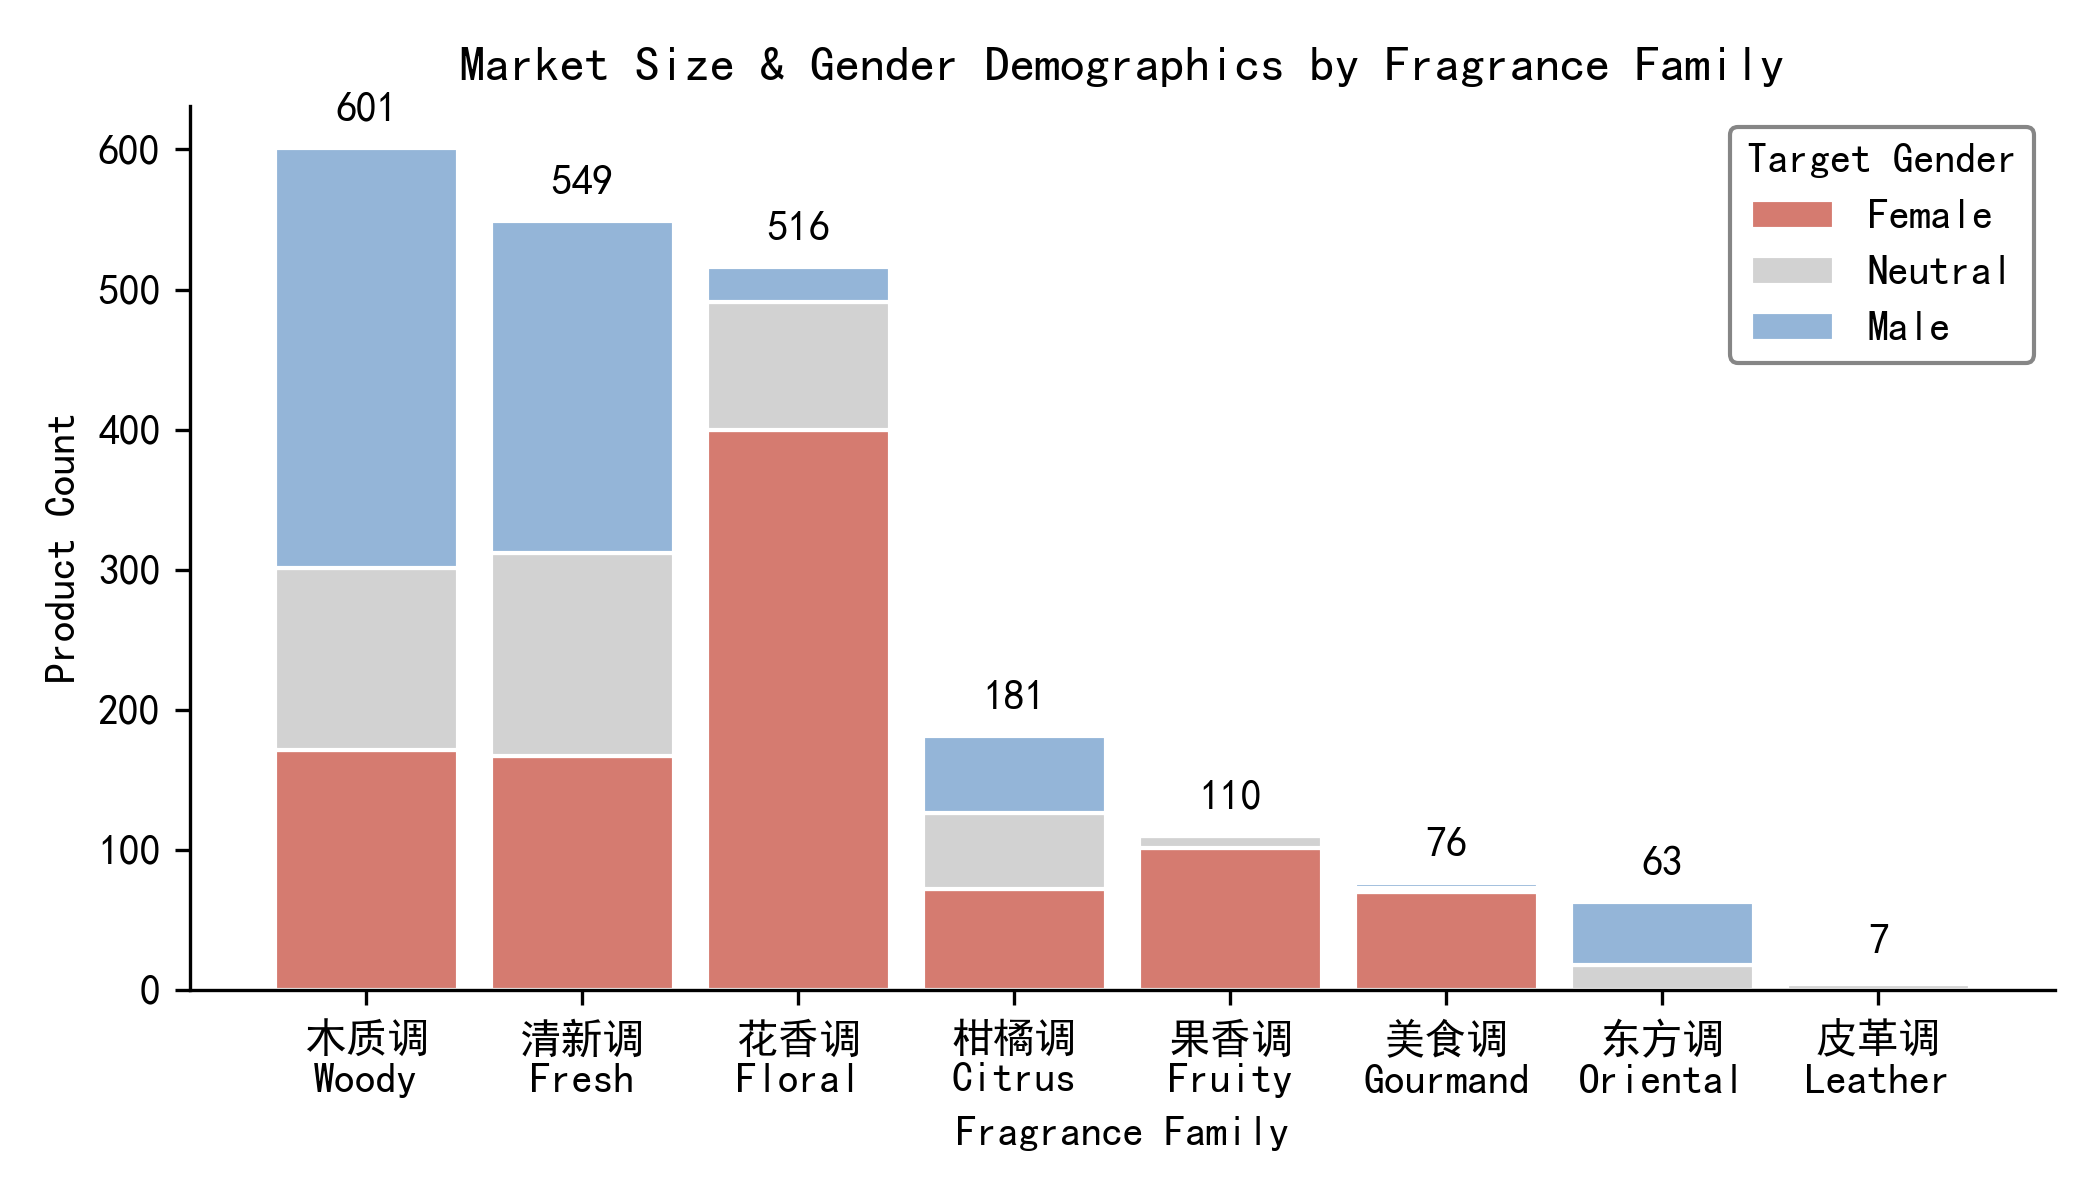

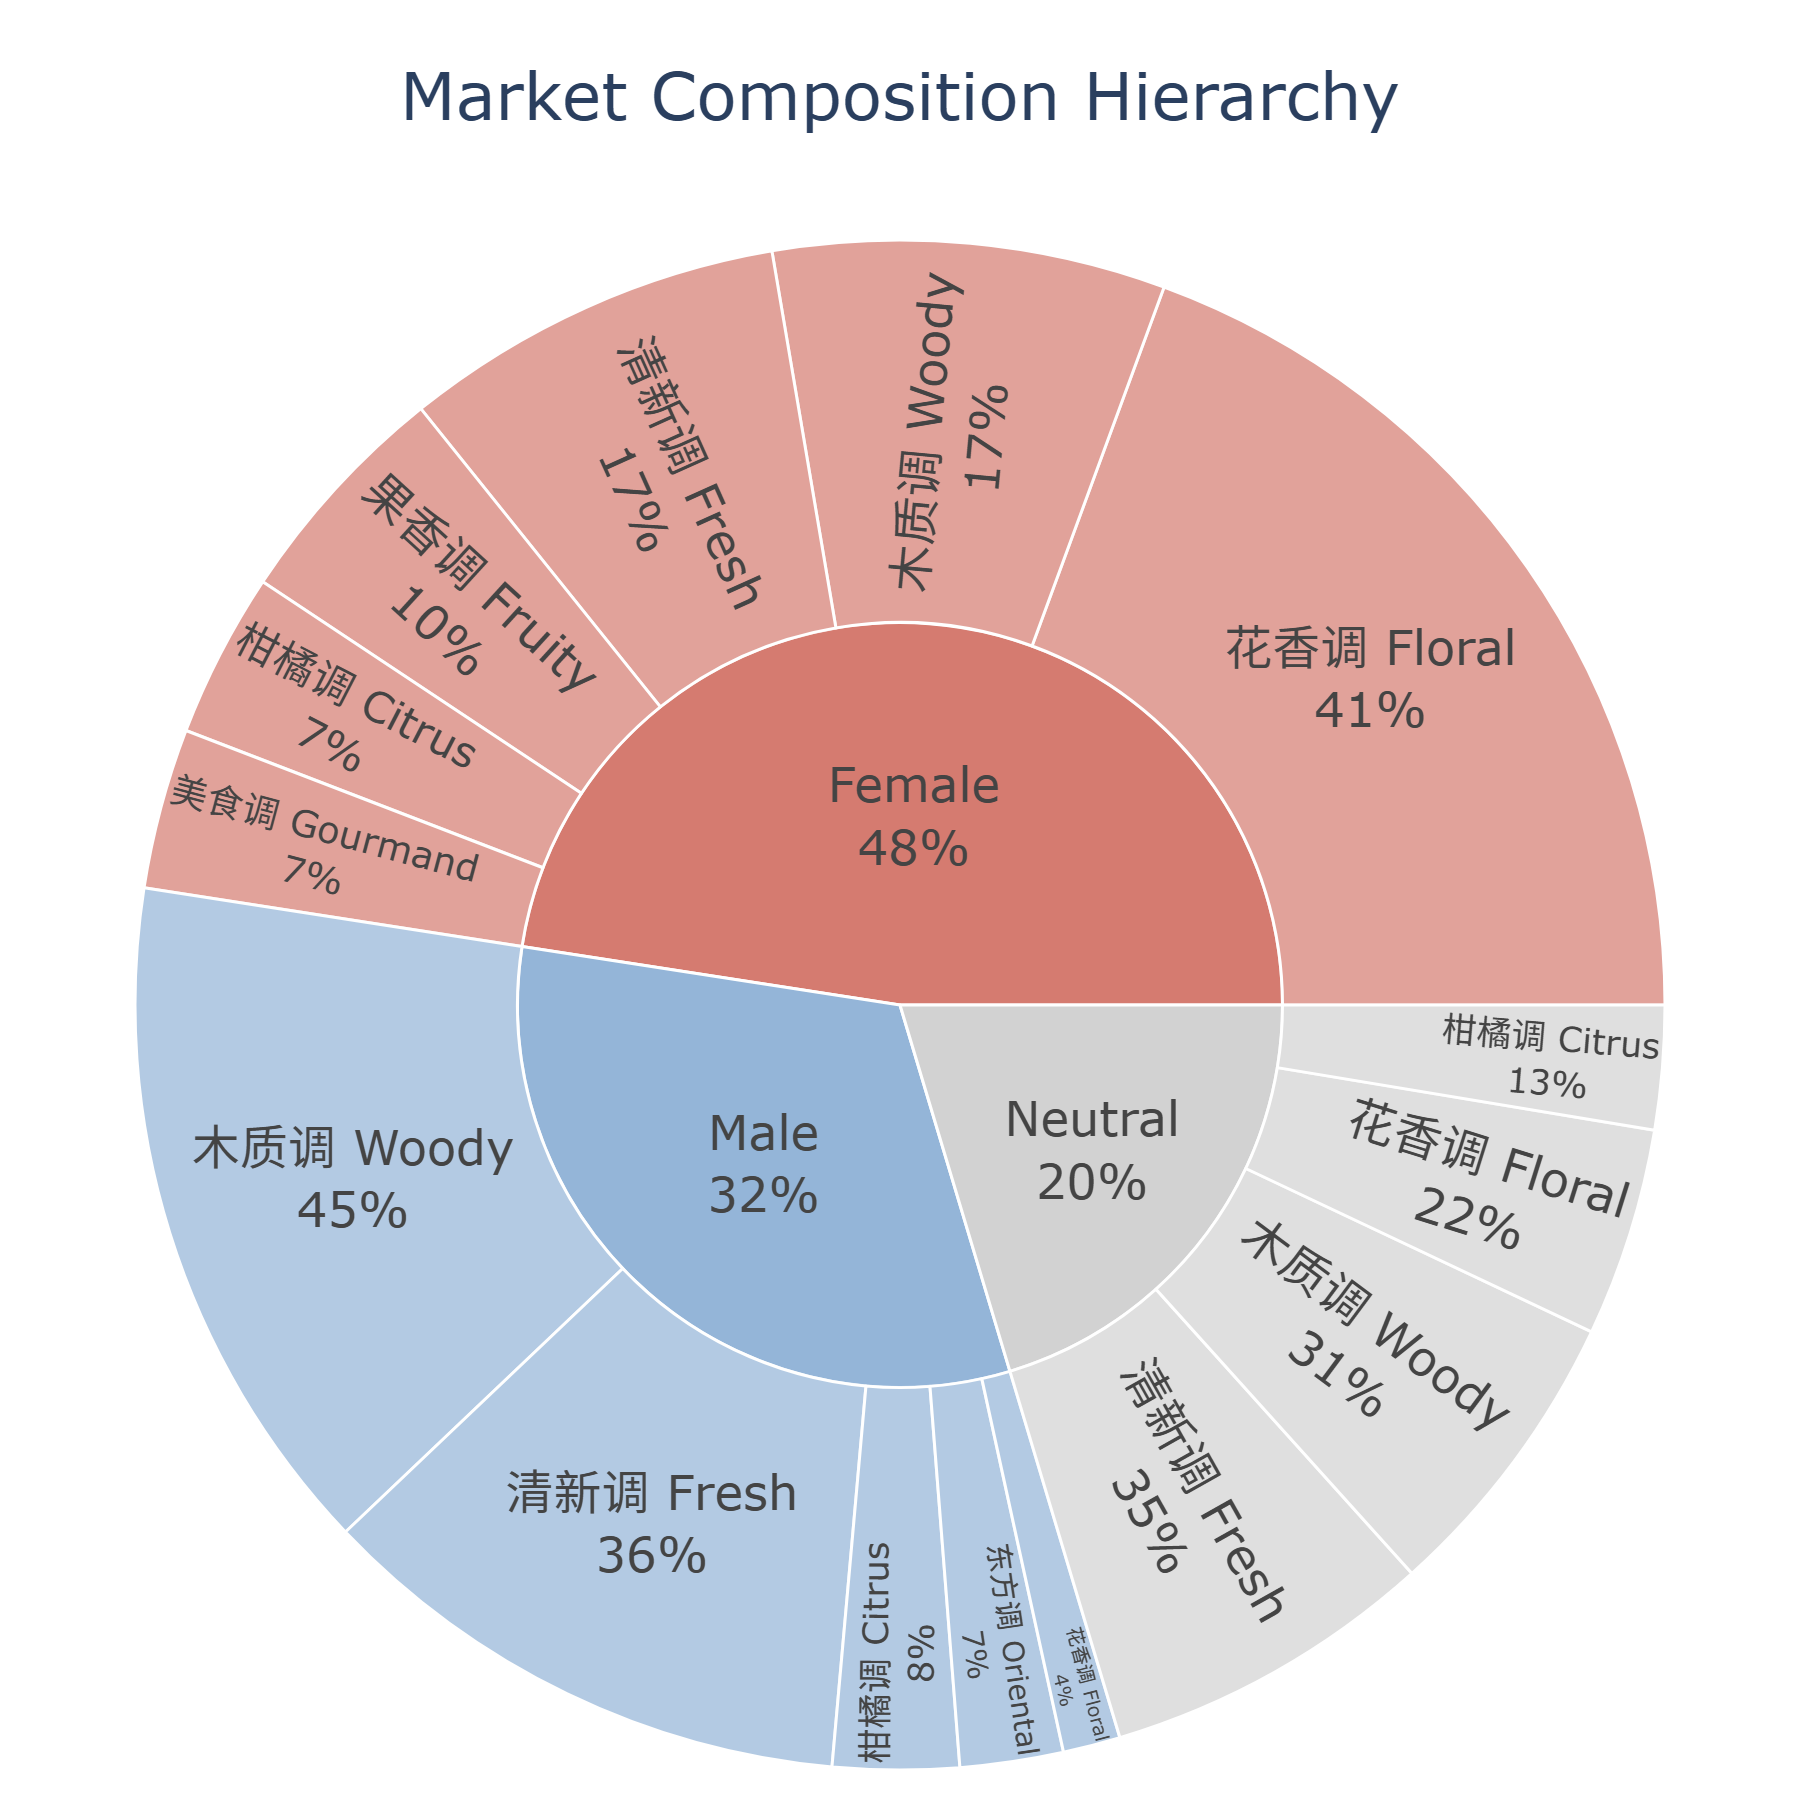

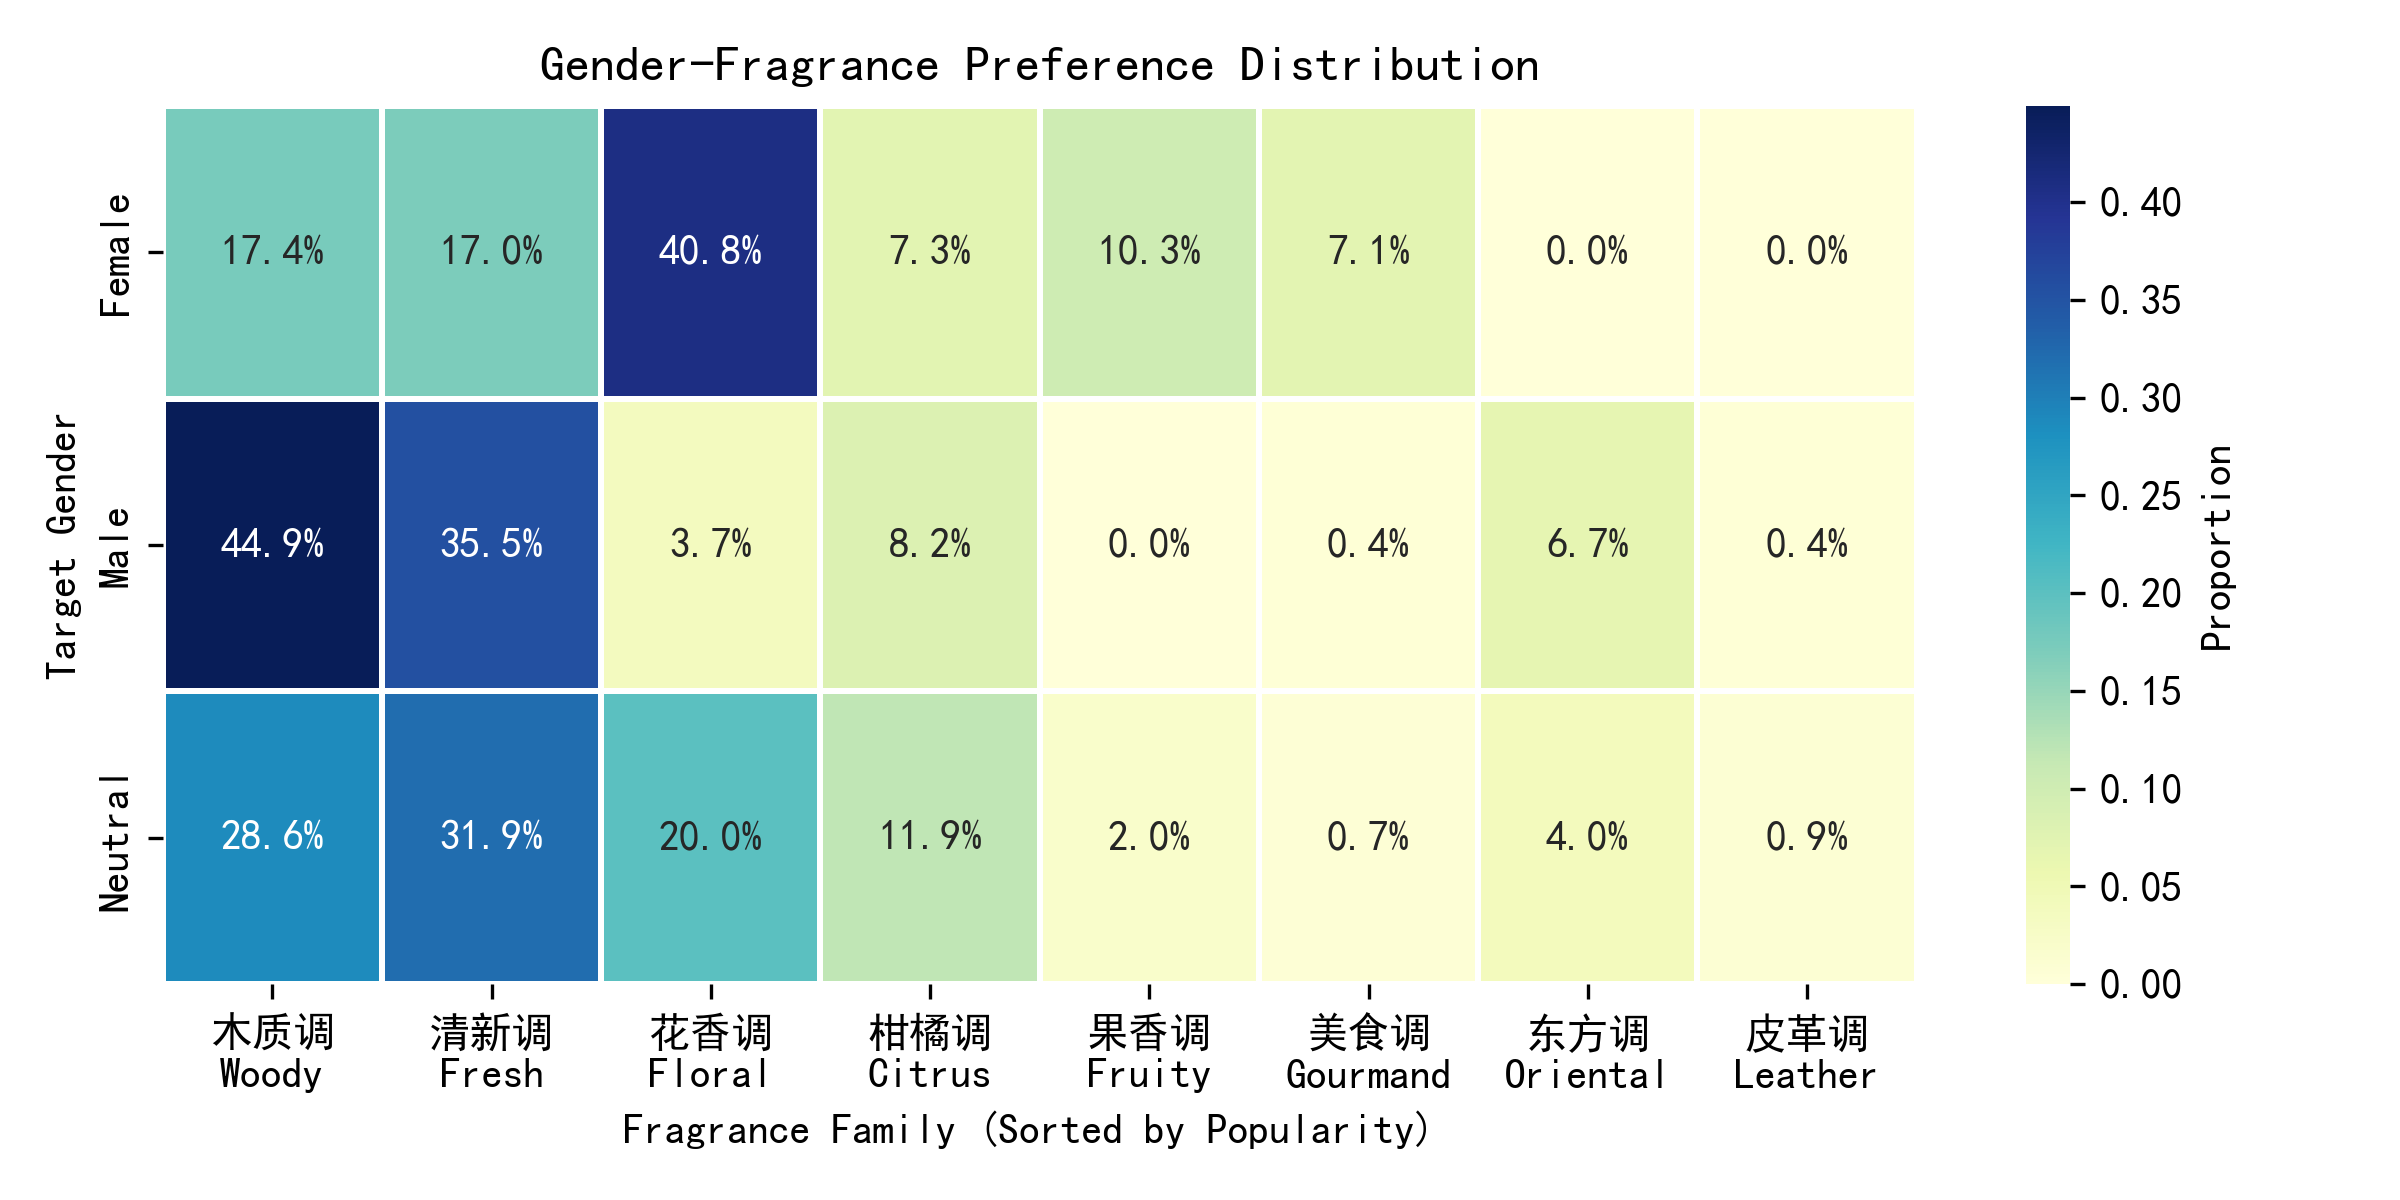

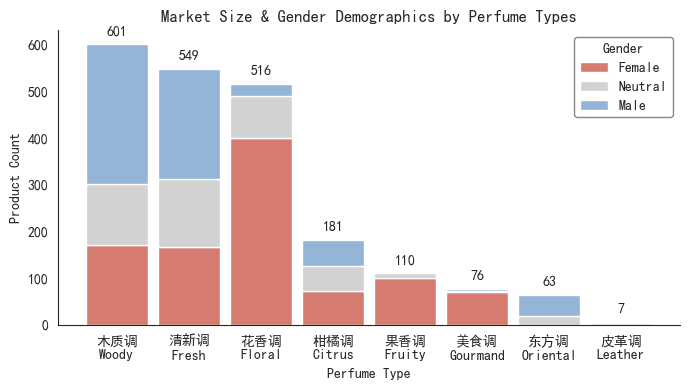

In [12]:
# Perfume Types Distribution by Gender

plt.figure(figsize=(7, 4))

valid_genders = ['male', 'female', 'neutral']
df_stack = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_stack['fragrance_en'] = df_stack['fragrance'].map(class_trans).fillna(df_stack['fragrance'])

ct_stack = pd.crosstab(df_stack['fragrance_en'], df_stack['gender'])

ct_stack['Total'] = ct_stack.sum(axis=1)
ct_stack = ct_stack.sort_values('Total', ascending=False)

categories = ct_stack.index
genders_order = ['female', 'neutral', 'male'] 
data_bottom = np.zeros(len(categories))

colors = {'female': '#D57B70', 'neutral': '#D2D2D2', 'male': '#94B5D8'}
labels = {'female': 'Female', 'neutral': 'Neutral', 'male': 'Male'}

for gender in genders_order:
    if gender in ct_stack.columns:
        values = ct_stack[gender].values
        plt.bar(categories, values, bottom=data_bottom, label=labels[gender], 
                color=colors[gender], edgecolor='white', width=0.85, linewidth=1)
        data_bottom += values

plt.title('Market Size & Gender Demographics by Perfume Types')
plt.xlabel('Perfume Type')
plt.ylabel('Product Count')

plt.legend(title='Gender', loc='upper right', frameon=True, framealpha=0.95, shadow=False, edgecolor='gray')

for i, total in enumerate(ct_stack['Total']):
    plt.text(i, total + 15, f"{int(total)}", ha='center', va='bottom')

plt.grid(False)
sns.despine()
plt.tight_layout()
plt.savefig("img/Market Size & Gender Demographics by Perfume Types.png", dpi=300)
plt.show()

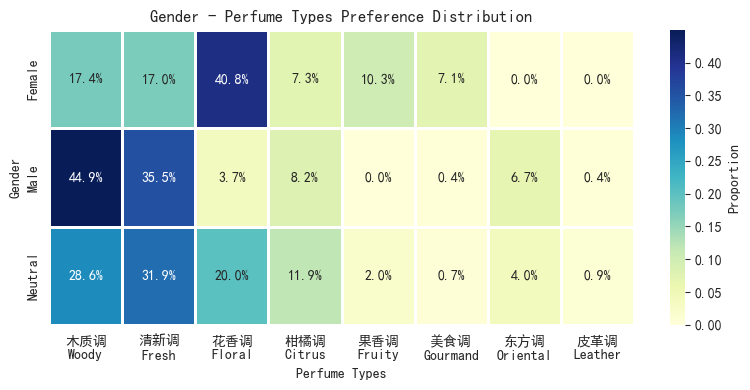

In [14]:
# Gender-Fragrance Heatmap
valid_genders = ['male', 'female', 'neutral']
df_heatmap = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_heatmap['fragrance_en'] = df_heatmap['fragrance'].map(class_trans).fillna(df_heatmap['fragrance'])
df_heatmap['gender_en'] = df_heatmap['gender'].map(class_trans).fillna(df_heatmap['gender'])

ct = pd.crosstab(df_heatmap['gender_en'], df_heatmap['fragrance_en'], normalize='index')

col_order = df_heatmap['fragrance_en'].value_counts().index
col_order = [c for c in col_order if c in ct.columns]
ct_sorted = ct[col_order]

plt.figure(figsize=(8, 4)) 

sns.heatmap(ct_sorted, annot=True, fmt='.1%', cmap='YlGnBu', 
            cbar_kws={'label': 'Proportion'},
            linewidths=1.0, linecolor='white')

plt.title('Gender - Perfume Types Preference Distribution')
plt.xlabel('Perfume Types')
plt.ylabel('Gender')

plt.tight_layout()
plt.savefig("img/Gender-Perfume Types Preference Distribution.png", dpi=300)
plt.show()

In [15]:
#  Market Composition Sunburst
df_sunburst = df_1976[df_1976['gender'].isin(['male', 'female', 'neutral'])].copy()

simple_trans_map = {k: v.split('\n')[0] + ' ' + v.split('\n')[1] for k, v in class_trans.items() if '\n' in v}
simple_trans_map.update({'male': 'Male', 'female': 'Female', 'neutral': 'Neutral'})

df_sunburst['gender_en'] = df_sunburst['gender'].map(simple_trans_map).fillna(df_sunburst['gender'])
df_sunburst['fragrance_en'] = df_sunburst['fragrance'].map(simple_trans_map).fillna(df_sunburst['fragrance'])

df_sb_count = df_sunburst.groupby(['gender_en', 'fragrance_en']).size().reset_index(name='count')
df_sb_count = df_sb_count[df_sb_count['count'] > 20]

fig = px.sunburst(
    df_sb_count, 
    path=['gender_en', 'fragrance_en'], 
    values='count',
    color='gender_en',
    color_discrete_map={
        'Female': '#D57B70',
        'Neutral': '#D2D2D2',
        'Male': '#94B5D8',
        '(?)': '#D2D2D2'
    },
    title='Market Composition Hierarchy'
)

fig.update_layout(
    width=600,
    height=600,
    margin=dict(t=80, l=10, r=10, b=10),
    font_size=16,
    template='plotly_white',
    title={'text': 'Market Composition Hierarchy', 'x': 0.5, 'xanchor': 'center'}
)
fig.update_traces(textinfo="label+percent parent")

fig.write_image("img/Market Composition Hierarchy.png", scale=3)
fig.show()


## Core Ingredients & Market Penetration

In this section, we delve into the specific ingredients that make up these perfumes. In addition to calculating the frequency of each note across the entire dataset, we conducted a segmented analysis of the perfume's three-note structure (Top, Middle, and Base notes) to reveal the dominant scents at different stages.

The analysis results indicate that **Musk** is the undisputed "King of Ingredients," appearing in 2103 perfumes. It predominantly appears as a **Base Note**, providing depth and longevity to the fragrance.

Through the breakdown analysis of the three notes (Dominant Ingredients Analysis), we discovered clear structural patterns:
*   **Top Notes**: **Bergamot** (601 counts) and **Citrus** (310 counts) hold absolute dominance. Fresh, volatile citrus notes are the top choice for opening the olfactory experience, with Lemon and Pink Pepper also being common top note elements.
*   **Middle Notes**: Floral notes dominate the core experience. **Jasmine** (372 counts) and **Rose** (259 counts) are the most classic middle note choices, followed closely by **Neroli** and **Lavender**, constructing the main character of the perfume.
*   **Base Notes**: Besides **Musk**, **Patchouli**, **Amber**, and **Cedar** all have extremely high frequencies (400+ counts), forming the warm, woody foundation of modern perfumes.

**Keyword Cloud Analysis:**
The word cloud visualization intuitively displays the relative weight of these ingredients. We can see that in addition to the core ingredients mentioned above, elements like **Vanilla** and **Tonka Bean** also have significant visibility. This combination reveals a market trend: consumers generally prefer perfumes with a fresh opening (Bergamot/Citrus), a rich floral heart (Jasmine/Rose), and a warm, steady base (Musk/Woody/Amber).

The figures below display the ranking of the Top 20 ingredients, the detailed distribution of ingredients across the three notes, and the word cloud of overall ingredient frequency:


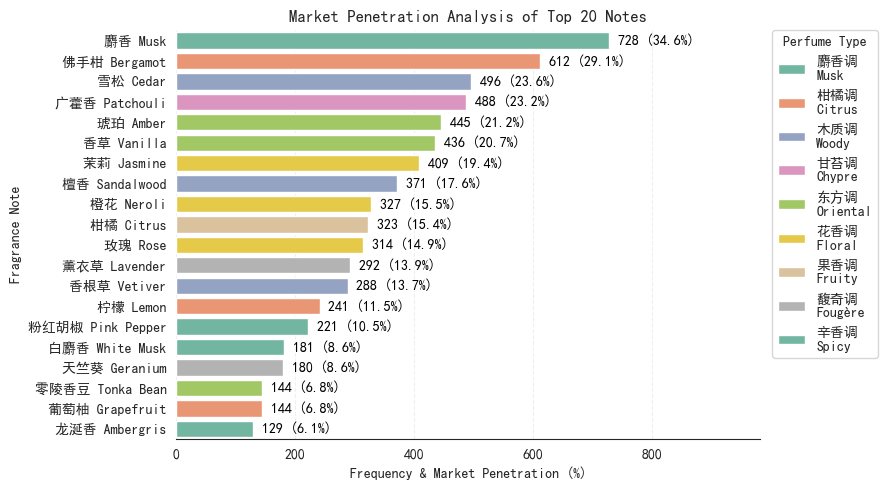

In [ ]:
# Note Frequency Top-K - Market Penetration Analysis

top_k = 20
total_perfumes = len(df_1976) 

df_top_notes = df_note_count.sort_values('count', ascending=False).head(top_k).copy()

note_trans = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris'
}
df_top_notes['note_en'] = df_top_notes['note'].map(note_trans).fillna(df_top_notes['note'])

df_top_notes['class'] = df_top_notes['class'].fillna('Other')
df_top_notes['class_en'] = df_top_notes['class'].map(class_trans).fillna(df_top_notes['class'])

df_top_notes['percentage'] = df_top_notes['count'] / total_perfumes * 100 

plt.figure(figsize=(9, 5)) 

ax = sns.barplot(data=df_top_notes, y='note_en', x='count', hue='class_en', dodge=False, palette='Set2')

plt.title(f'Market Penetration Analysis of Top {top_k} Notes')
plt.xlabel('Frequency & Market Penetration (%)')
plt.ylabel('Fragrance Note')

plt.legend(title='Perfume Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        percentage = (width / total_perfumes) * 100
        label_text = f'{int(width)} ({percentage:.1f}%)'
        ax.text(width + 15, p.get_y() + p.get_height()/2.,
                label_text,
                ha='left', va='center', color='black')

max_width = df_top_notes['count'].max()
plt.xlim(0, max_width * 1.35)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.savefig("img/Top-K Note Frequency Market Penetration Analysis.png", dpi=300)
plt.show()

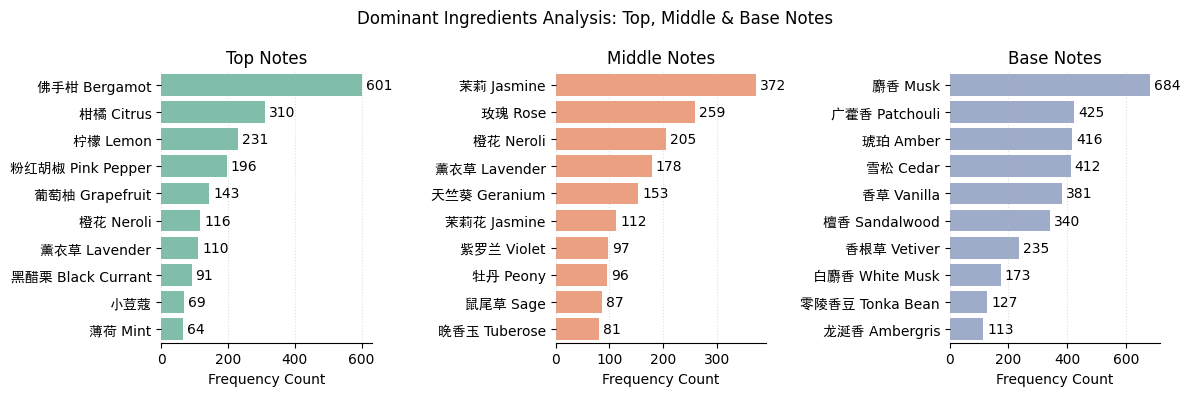

In [2]:
# Top 10 Notes Distribution by Olfactory Pyramid Position

def get_note_counts(df, column):
    all_notes = []
    for notes in df[column].dropna():
        cleaned = notes.replace('、', ',').replace(' ', '')
        all_notes.extend([n.strip() for n in cleaned.split(',') if n.strip()])
    return pd.Series(Counter(all_notes)).sort_values(ascending=False)

top_counts = get_note_counts(df_1976, 'top_notes').head(10)
mid_counts = get_note_counts(df_1976, 'middle_notes').head(10)
base_counts = get_note_counts(df_1976, 'base_notes').head(10)

note_trans_map = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris', '依兰': '依兰 Ylang-Ylang',
    '紫罗兰': '紫罗兰 Violet', '鸢尾花': '鸢尾花 Iris', '橡木苔': '橡木苔 Oakmoss',
    '安息香': '安息香 Benzoin', '皮革': '皮革 Leather', '黑胡椒': '黑胡椒 Black Pepper',
    '肉豆蔻': '肉豆蔻 Nutmeg', '小豆蔻': '小豆蔻 Cardamom', '生姜': '生姜 Ginger',
    '薄荷': '薄荷 Mint', '罗勒': '罗勒 Basil', '鼠尾草': '鼠尾草 Sage',
    '百合': '百合 Lily', '铃兰': '铃兰 Lily of the Valley', '晚香玉': '晚香玉 Tuberose',
    '桃子': '桃子 Peach', '苹果': '苹果 Apple', '黑醋栗': '黑醋栗 Black Currant',
    '梨': '梨 Pear', '菠萝': '菠萝 Pineapple', '椰子': '椰子 Coconut',
    '橘子': '橘子 Mandarin', '沉香': '沉香 Oud', '劳丹脂': '劳丹脂 Labdanum',
    '牡丹': '牡丹 Peony', '小苍兰': '小苍兰 Freesia', '香柠檬': '香柠檬 Bergamot',
    '茉莉花': '茉莉花 Jasmine', '檀香木': '檀香木 Sandalwood', '檀木': '檀木 Sandalwood',
    '雪松木': '雪松木 Cedar', '橡苔': '橡苔 Oakmoss', '乳香': '乳香 Frankincense',
    '没药': '没药 Myrrh', '鸢尾': '鸢尾 Iris', '水蜜桃': '水蜜桃 Peach',
    '杏': '杏 Apricot', '黑加仑': '黑加仑 Blackcurrant', '肉桂': '肉桂 Cinnamon',
    '丁香': '丁香 Clove', '芫荽': '芫荽 Coriander', '丝柏': '丝柏 Cypress',
    '尤加利': '尤加利 Eucalyptus', '无花果': '无花果 Fig', '栀子花': '栀子花 Gardenia',
    '风信子': '风信子 Hyacinth', '杜松子': '杜松子 Juniper Berry', '青柠': '青柠 Lime',
    '木兰': '木兰 Magnolia', '苔藓': '苔藓 Moss', '桂花': '桂花 Osmanthus',
    '李子': '李子 Plum', '藏红花': '藏红花 Saffron', '烟草': '烟草 Tobacco',
    '柚子': '柚子 Yuzu', '香柠檬': '香柠檬 Bergamot'
}

positions = ['Top Notes', 'Middle Notes', 'Base Notes']
data_list = [top_counts, mid_counts, base_counts]

colors = ['#66C2A5', '#FC8D62', '#8DA0CB'] 

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

for i, (ax, data, title, color) in enumerate(zip(axes, data_list, positions, colors)):
    labels = [note_trans_map.get(n, n) for n in data.index]

    bars = sns.barplot(x=data.values, y=labels, ax=ax, color=color, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('Frequency Count')
    ax.tick_params(axis='y')
    ax.tick_params(axis='x')

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + max(data.values)*0.02, p.get_y() + p.get_height()/2, 
                f'{int(width)}', ha='left', va='center')
    
    # Remove borders
    sns.despine(left=True, bottom=False, ax=ax)
    
    # Add light grid for readability
    ax.grid(axis='x', linestyle=':', alpha=0.4)
    ax.set_ylabel('') # Remove y-label as it's self-explanatory

plt.suptitle('Dominant Ingredients Analysis: Top, Middle & Base Notes')
plt.tight_layout()
plt.savefig("img/Dominant Ingredients Analysis Top Middle Base Notes.png", dpi=400)
plt.show()

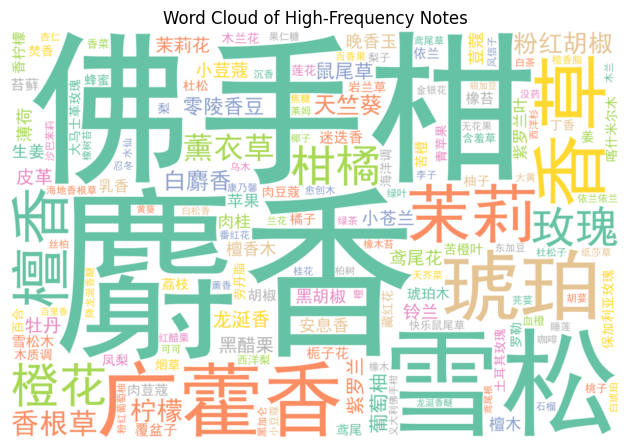

In [3]:
# Note Word Cloud
from wordcloud import WordCloud
import os

frequencies = df_note_count.set_index('note')['count'].to_dict()

font_path = 'C:/Windows/Fonts/simhei.ttf'
if not os.path.exists(font_path):
    import matplotlib.font_manager
    try:
        font_path = matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties(family=['SimHei']))
    except:
        font_path = None 

wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=1200,
    height=800,
    max_words=150,
    colormap='Set2',
    random_state=42,
    prefer_horizontal=0.9
)

wc.generate_from_frequencies(frequencies)

plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of High-Frequency Notes')
plt.tight_layout()
plt.savefig("img/Word Cloud of High-Frequency Notes.png", dpi=400)
plt.show()

## Olfactory Structure & Complexity

Finally, we turn our attention to the internal structure of perfumes, using Sankey Diagrams and Boxplots to explore the flow path of scents and formula complexity.

**Olfactory Flow Path:**
The Sankey diagram vividly illustrates the evolutionary logic of perfumes from **Top -> Middle -> Base notes**.
*   **Classic Path**: The most prominent flow path starts with **Citrus/Fruity** notes, transitions to a **Floral** core, and finally settles into a **Musk/Woody** base. This "Fresh-Soft-Warm" three-stage structure constitutes the mainstream skeleton of modern commercial perfumes.
*   **Structural Differences**: We observe that male perfumes tend towards the hard lines of "Citrus -> Aromatic/Spicy -> Woody", while female perfumes present more of the soft curves of "Fruity -> Floral -> Musk/Amber".
*   **Neutral Aesthetics**: Neutral perfumes showcase a unique beauty of balance, often opening with fresh **Citrus** or **Green** notes, blending **Floral** and **Woody** characteristics in the middle, and finally returning to the steadiness of **Musk** or **Woody** notes, breaking the traditional olfactory boundaries of gender.

**Formula Complexity:**
We measure "complexity" by calculating the number of ingredients contained in each perfume and use boxplots to compare the formula richness of different fragrance families.
*   **Spectrum of Complexity**: **Chypre** and **Oriental** notes typically possess the highest median number of ingredients, representing the traditional aesthetic of grand structures and rich layers.
*   **Minimalism**: In contrast, **Fresh** notes or single floral perfumes have simpler formulas, emphasizing the purity of a single element.
*   **Dispersion**: The distribution range of the boxplot also reveals that certain fragrance families (such as Woody notes) have great elasticity in formula complexity, ranging from minimalist modern works to complex classical pieces.

The figures below display the Sankey diagram of the three-note flow and the complexity distribution of different fragrance types:


In [8]:
# Sankey Diagram - Olfactory Pyramid Structure Analysis

def get_dominant_class_en(notes_str):
    if pd.isna(notes_str): return None
    notes = [n.strip() for n in notes_str.replace('、', ',').split(',')]
    classes = [note_class_map.get(n, '其他') for n in notes]
    if not classes: return 'Other'
    dom_class = Counter(classes).most_common(1)[0][0]
    trans_map = {
        '花香调': '花香调 Floral', '木质调': '木质调 Woody', '东方调': '东方调 Oriental', 
        '柑橘调': '柑橘调 Citrus', '果香调': '果香调 Fruity', '馥奇调': '馥奇调 Fougère', 
        '绿叶调': '绿叶调 Green', '水生调': '水生调 Aquatic', '甘苔调': '甘苔调 Chypre', 
        '皮革调': '皮革调 Leather', '美食调': '美食调 Gourmand', '辛香调': '辛香调 Spicy',
        '醛香调': '醛香调 Aldehyde', '素心兰调': '素心兰调 Chypre', '清新调': '清新调 Fresh', 
        '其他': '其他 Other',
        '木质香调': '木质调 Woody', '美食香调': '美食调 Gourmand', '皮革香调': '皮革调 Leather', 
        '青香调': '青香调 Green', '海洋调': '海洋调 Marine', '麝香调': '麝香调 Musk', 
        '柑苔香调': '柑苔调 Chypre', '树脂调': '树脂调 Resinous', '概念性': '概念性 Conceptual'
    }
    if dom_class not in trans_map and dom_class in class_trans:
        val = class_trans[dom_class]
        if '\n' in val:
            trans_map[dom_class] = val.replace('\n', ' ')
    return trans_map.get(dom_class, dom_class)

sankey_data = []
for _, row in df_1976.iterrows():
    top = get_dominant_class_en(row['top_notes'])
    mid = get_dominant_class_en(row['middle_notes'])
    base = get_dominant_class_en(row['base_notes'])
    if top and mid:
        sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
    if mid and base:
        sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

df_sankey = pd.DataFrame(sankey_data)
df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
df_sankey = df_sankey[df_sankey['value'] > 30] 

all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
node_map = {node: i for i, node in enumerate(all_nodes)}
node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = all_nodes,
      color = node_colors
    ),
    link = dict(
      source = [node_map[s] for s in df_sankey['source']],
      target = [node_map[t] for t in df_sankey['target']],
      value = df_sankey['value'],
      color = "rgba(200, 200, 200, 0.5)" 
  ))])

fig.update_layout(
    title={'text': "Structural Analysis of Olfactory Pyramid Flow", 'x': 0.5, 'xanchor': 'center'},
    font_size=16,
    width=900,
    height=600,
    template='plotly_white',
    margin=dict(t=60, l=10, r=10, b=10)
)
fig.write_image("img/Olfactory_Pyramid_Sankey.png", scale=3)
fig.show()

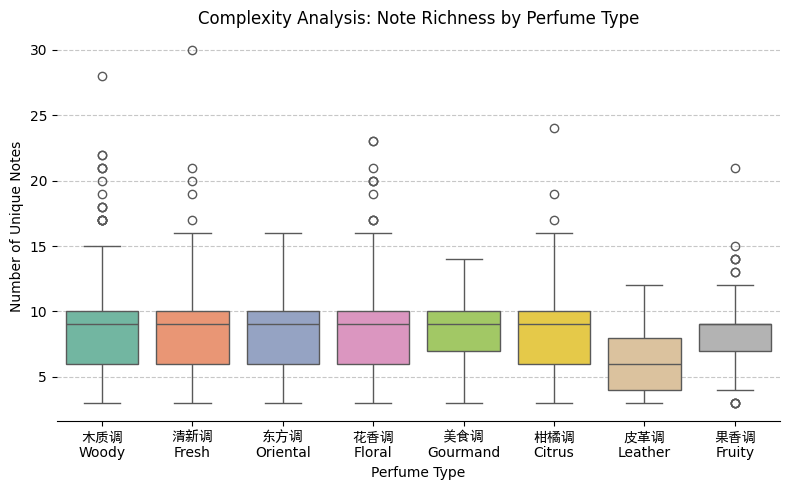

In [4]:
# Note Richness vs Fragrance Type

def count_notes(row):
    notes = []
    for col in ['top_notes', 'middle_notes', 'base_notes']:
        if pd.notna(row[col]):
            notes.extend(row[col].replace('、', ',').split(','))
    return len(set(notes))

df_1976['note_count'] = df_1976.apply(count_notes, axis=1)
df_1976['fragrance_en'] = df_1976['fragrance'].map(class_trans).fillna(df_1976['fragrance'])

top_fragrances = df_1976['fragrance_en'].value_counts().head(12).index
df_box = df_1976[df_1976['fragrance_en'].isin(top_fragrances)]

plt.figure(figsize=(8, 5))

sns.boxplot(x='fragrance_en', y='note_count', data=df_box, palette="Set2")

plt.title('Complexity Analysis: Note Richness by Perfume Type')
plt.xlabel('Perfume Type')
plt.ylabel('Number of Unique Notes')

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("img/Complexity Analysis Note Richness by Fragrance Family.png", dpi=300)
plt.show()

In [10]:
# Gender-Specific Sankey Diagrams
def plot_gender_sankey(target_gender, title_text, threshold=15, filename=None):
    df_gender = df_1976[df_1976['gender'] == target_gender]
    
    sankey_data = []
    for _, row in df_gender.iterrows():
        top = get_dominant_class_en(row['top_notes'])
        mid = get_dominant_class_en(row['middle_notes'])
        base = get_dominant_class_en(row['base_notes'])
        
        if top and mid:
            sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
        if mid and base:
            sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

    if not sankey_data:
        print(f"No data for {target_gender}")
        return

    df_sankey = pd.DataFrame(sankey_data)
    df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
    df_sankey = df_sankey[df_sankey['value'] > threshold] 

    all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
    node_map = {node: i for i, node in enumerate(all_nodes)}

    node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 12,
          thickness = 22,
          line = dict(color = "black", width = 0.3),
          label = all_nodes,
          color = node_colors
        ),
        link = dict(
          source = [node_map[s] for s in df_sankey['source']],
          target = [node_map[t] for t in df_sankey['target']],
          value = df_sankey['value'],
          color = "rgba(200, 200, 200, 0.5)" 
      ))])

    fig.update_layout(
        title={'text': title_text, 'x': 0.5, 'xanchor': 'center'},
        font_size=14,
        width=700,
        height=480,
        template='plotly_white',
        margin=dict(t=50, l=5, r=5, b=5)
    )
    if filename:
        fig.write_image(filename, scale=3)
    fig.show()

# Plot for Male
plot_gender_sankey('male', "Olfactory Structure Flow - Male Perfumes", threshold=10, filename="img/sankey_male.png")

# Plot for Female
plot_gender_sankey('female', "Olfactory Structure Flow - Female Perfumes", threshold=20, filename="img/sankey_female.png")

# Plot for Neutral
plot_gender_sankey('neutral', "Olfactory Structure Flow - Neutral Perfumes", threshold=10, filename="img/sankey_neutral.png")